<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/Lecture_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use LSTM networks to predict the stock market
- Based on Siraj Raval's https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo
- Which was based on  Jakob Aungiers' https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction
- Modified by James Green, Oct 2019

In [1]:
# Helper functions:

import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore")

# Function to plot the predictions of non-overlapping windows.
# Start with a full window of test data, then predict until window_len 
# predictions have been made. Then start over with a new window of test data.
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


# Function to load the data from CSV file, then generate overlapping windows of 
# data. Each window is normalized WRT to the first point in the window
def load_data(URL, seq_len, normalise_window):
    pd_data = pd.read_csv(URL)
    data = pd_data.values
    #f = open(filename, 'r').read()
    #data = f.split('\n')

    # Split up the data into a bunch of overlapping sequence windows
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Function to normalize a window of data by the first point
# First point becomes 0, then subsequent points are % difference from initial
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


# Function to predict 50 steps into the future, then reload model with new
# window of data. Repeat...
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

Using TensorFlow backend.


In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries

In [0]:
#Step 1 Load Data
URL = 'https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/raw/master/sp500.csv'
X_train, y_train, X_test, y_test = load_data(URL, 50, True)

In [4]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

W1011 20:45:20.918500 140220318136192 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1011 20:45:20.922646 140220318136192 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1011 20:45:20.926425 140220318136192 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1011 20:45:21.116807 140220318136192 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1011 20:45:21.127907 140220318136192 depr

compilation time :  0.0217740535736


In [10]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=50,
    validation_split=0.05)

Train on 3521 samples, validate on 186 samples
Epoch 1/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.4361e-04 - val_loss: 3.9551e-04
Epoch 2/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.1993e-04 - val_loss: 3.3699e-04
Epoch 3/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.2319e-04 - val_loss: 2.9960e-04
Epoch 4/50
3521/3521 [==============================] - 4s 1ms/step - loss: 2.8943e-04 - val_loss: 3.7147e-04
Epoch 5/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.3656e-04 - val_loss: 3.4052e-04
Epoch 6/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.0613e-04 - val_loss: 3.1067e-04
Epoch 7/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.0802e-04 - val_loss: 3.4844e-04
Epoch 8/50
3521/3521 [==============================] - 4s 1ms/step - loss: 3.0358e-04 - val_loss: 2.7452e-04
Epoch 9/50
3521/3521 [==============================] - 4s 1ms/step - los

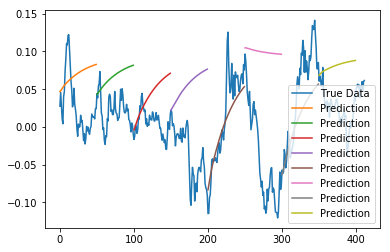

In [11]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)